# Uniform grating coupler


In [1]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web


## Problem Setup

In this example, we model a 3D grating coupler in a Silicon on Insulator (SOI) platform.

A basic schematic of the design is shown below.  The simulation is about 19um x 4um x 5um with a wavelength of 1.55um and takes about 1 minute to simulate 10,000 time steps.

In the simulation, we inject a modal source into the waveguide and propagate it towards the grating structure.  The radiation from the grating coupler is then measured with a near field monitor and we use a far field projection to inspect the angular dependence of the radiation.

<img src="img/grating_coupler.png" width=600 alt="Schematic of the grating coupler">

In addition to the uniform grating coupler modeled here, we also studied a [focusing apodized grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/FocusedApodGC/) and an [inverse designed compact grating coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin6GratingCoupler/) in our case studies. Besides grating couplers, we have also investigated an [inverse taper edge coupler](https://www.flexcompute.com/tidy3d/examples/notebooks/EdgeCoupler/).

If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials. 

In [2]:
# basic parameters (note, all length units are microns)
nm = 1e-3
wavelength = 1550 * nm

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wavelength)

# waveguide
wg_width = 400 * nm
wg_height = 220 * nm
wg_length = 2 * wavelength

# surrounding
sub_height = 2.0
air_height = 2.0
buffer = 0.5 * wavelength

# coupler
cp_width = 4 * wavelength
cp_length = 8 * wavelength
taper_length = 6 * wavelength


In [3]:
# sizes
Lx = buffer + wg_length + taper_length + cp_length
Ly = buffer + cp_width + buffer
Lz = sub_height + wg_height + air_height
sim_size = [Lx, Ly, Lz]

# convenience variables to store center of coupler and waveguide
wg_center_x = +Lx / 2 - buffer - (wg_length + taper_length) / 2
cp_center_x = -Lx / 2 + buffer + cp_length / 2
wg_center_z = -Lz / 2 + sub_height + wg_height / 2
cp_center_z = -Lz / 2 + sub_height + wg_height / 2

# materials
Air = td.Medium(permittivity=1.0)
Si = td.Medium(permittivity=3.47**2)
SiO2 = td.Medium(permittivity=1.44**2)

# source parameters
freq0 = td.C_0 / wavelength
fwidth = freq0 / 10
run_time = 100 / fwidth


## Mode Solve
To determine the pitch of the waveguide for a given design angle, we need to compute the effective index of the waveguide mode being coupled into.  For this, we set up a simple simulation of the coupler region and use the mode solver to get the effective index. We will not run this simulation, we just add a ``ModeMonitor`` object in order to construct and run the mode solver below, and get the effective index of the wide-waveguide region. 

Note: because the simulation is just being used for the mode solver, we can safely ignore the warning about lack of sources.

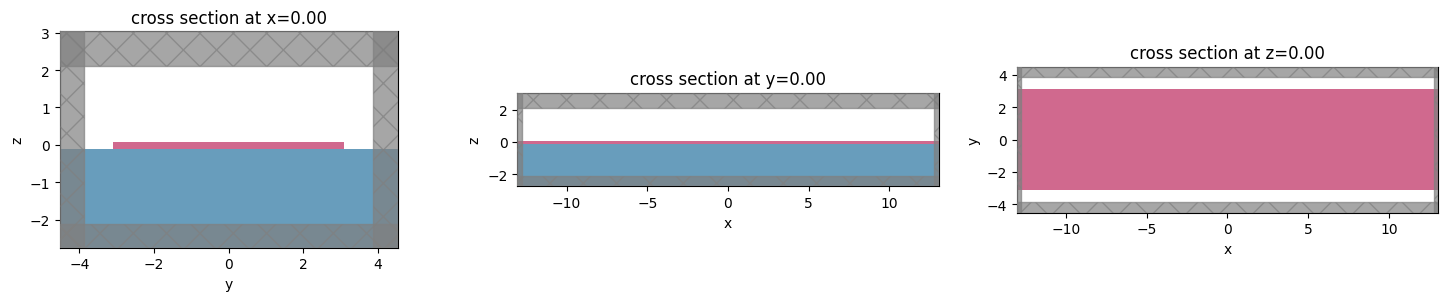

In [4]:
# grating parameters
design_theta_deg = -30
design_theta_rad = np.pi * design_theta_deg / 180
grating_height = 70 * nm

# do a mode solve to get neff of the coupler

sub = td.Structure(
    geometry=td.Box(center=[0, 0, -Lz / 2], size=[td.inf, td.inf, 2 * sub_height]),
    medium=SiO2,
    name="substrate",
)

cp = td.Structure(
    geometry=td.Box(
        center=[0, 0, cp_center_z - grating_height / 4],
        size=[td.inf, cp_width, wg_height - grating_height / 2],
    ),
    medium=Si,
    name="coupler",
)

mode_plane = td.Box(center=(0, 0, 0), size=(0, 8 * cp_width, 8 * wg_height))


sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[sub, cp],
    sources=[],
    monitors=[],
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    run_time=1e-12,
)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
sim.plot(x=0, ax=ax1)
sim.plot(y=0, ax=ax2)
sim.plot(z=0, ax=ax3)
plt.show()


## Compute Effective index for Grating Pitch Design

In [5]:
from tidy3d.plugins.mode import ModeSolver

ms = ModeSolver(
    simulation=sim, plane=mode_plane, mode_spec=td.ModeSpec(), freqs=[freq0]
)
mode_output = ms.solve()


12:51:48 UTC WARNING: Use the remote mode solver with subpixel averaging for    
             better accuracy through 'tidy3d.plugins.mode.web.run(...)'.        

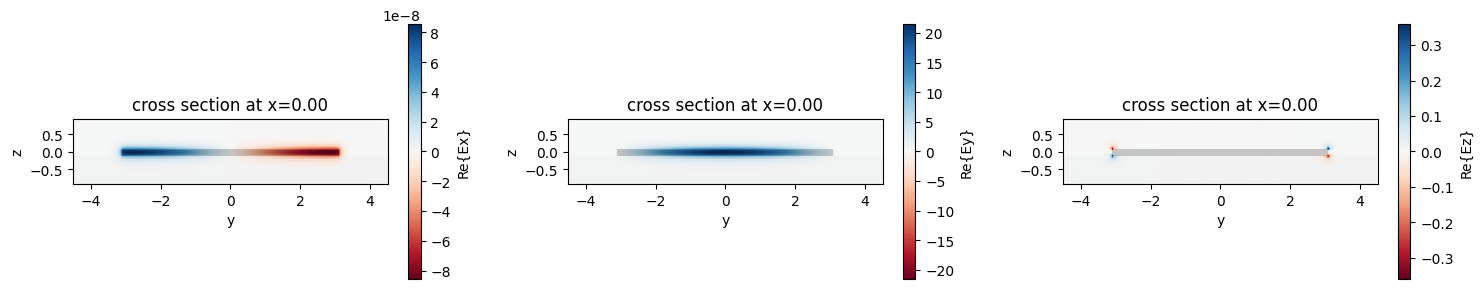

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
ms.plot_field("Ex", val="real", robust=False, ax=ax1)
ms.plot_field("Ey", val="real", robust=False, ax=ax2)
ms.plot_field("Ez", val="real", robust=False, ax=ax3)
plt.show()


In [7]:
neff = float(mode_output.n_eff)
print(f"effective index = {neff:.4f}")


effective index = 2.6886


## Create Simulation
Now we set up the grating coupler to simulate in Tidy3D.

In [8]:
# gratings
pitch = wavelength / (neff - np.sin(abs(design_theta_rad)))
grating_length = pitch / 2.0
num_gratings = int(cp_length / pitch)

sub = td.Structure(
    geometry=td.Box(
        center=[0, 0, -Lz / 2],
        size=[td.inf, td.inf, 2 * sub_height],
    ),
    medium=SiO2,
    name="substrate",
)

wg = td.Structure(
    geometry=td.Box(
        center=[wg_center_x, 0, wg_center_z],
        size=[buffer + wg_length + taper_length + cp_length / 2, wg_width, wg_height],
    ),
    medium=Si,
    name="waveguide",
)

cp = td.Structure(
    geometry=td.Box(
        center=[cp_center_x, 0, cp_center_z],
        size=[cp_length, cp_width, wg_height],
    ),
    medium=Si,
    name="coupler",
)

tp = td.Structure(
    geometry=td.PolySlab(
        vertices=[
            [cp_center_x + cp_length / 2 + taper_length, +wg_width / 2],
            [cp_center_x + cp_length / 2 + taper_length, -wg_width / 2],
            [cp_center_x + cp_length / 2, -cp_width / 2],
            [cp_center_x + cp_length / 2, +cp_width / 2],
        ],
        slab_bounds=(wg_center_z - wg_height / 2, wg_center_z + wg_height / 2),
        axis=2,
    ),
    medium=Si,
    name="taper",
)

grating_left_x = cp_center_x - cp_length / 2
gratings = [
    td.Structure(
        geometry=td.Box(
            center=[
                grating_left_x + (i + 0.5) * pitch,
                0,
                cp_center_z + wg_height / 2 - grating_height / 2,
            ],
            size=[grating_length, cp_width, grating_height],
        ),
        medium=Air,
        name=f"{i}th_grating",
    )
    for i in range(num_gratings)
]


In [9]:
# distance to near field monitor
nf_offset = 50 * nm

plane_monitor = td.FieldMonitor(
    center=[0, 0, cp_center_z],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="full_domain_fields",
)

rad_monitor = td.FieldMonitor(
    center=[0, 0, 0], size=[td.inf, 0, td.inf], freqs=[freq0], name="radiated_fields"
)

near_field_monitor = td.FieldMonitor(
    center=[cp_center_x, 0, cp_center_z + wg_height / 2 + nf_offset],
    size=[td.inf, td.inf, 0],
    freqs=[freq0],
    name="radiated_near_fields",
)


In [10]:
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[sub, wg, cp, tp] + gratings,
    sources=[],
    monitors=[plane_monitor, rad_monitor, near_field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)


### Make Modal Source

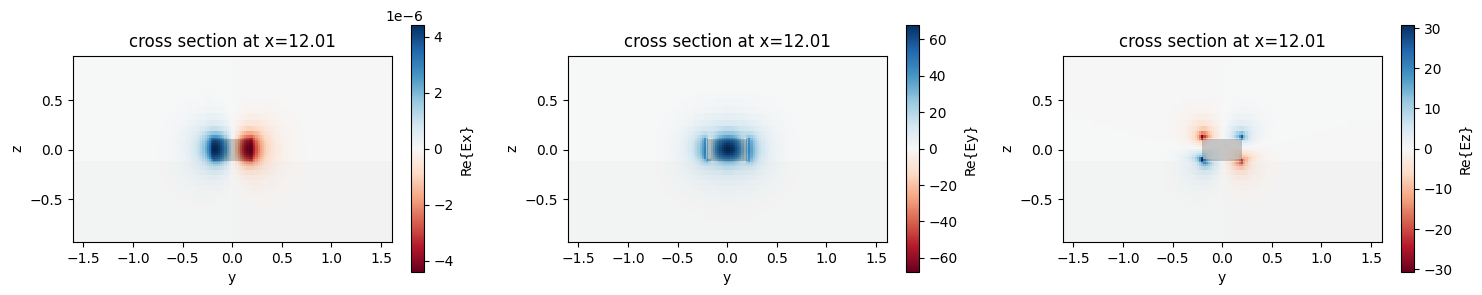

In [11]:
source_plane = td.Box(
    center=[Lx / 2 - buffer, 0, cp_center_z],
    size=[0, 8 * wg_width, 8 * wg_height],
)

ms = ModeSolver(
    simulation=sim, plane=source_plane, mode_spec=td.ModeSpec(), freqs=[freq0]
)
mode_output = ms.solve()

f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(15, 3))
ms.plot_field("Ex", val="real", robust=False, ax=ax1)
ms.plot_field("Ey", val="real", robust=False, ax=ax2)
ms.plot_field("Ez", val="real", robust=False, ax=ax3)
plt.show()


In [12]:
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_src = ms.to_source(mode_index=0, direction="-", source_time=source_time)
sim = sim.copy(update={"sources": [mode_src]})


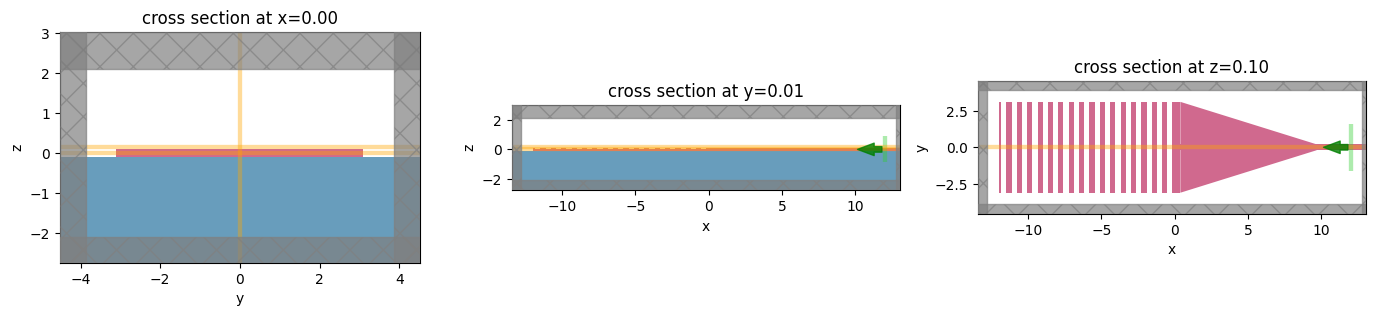

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(14, 3))
sim.plot(x=0, ax=ax1)
sim.plot(y=0.01, ax=ax2)
sim.plot(z=0.1, ax=ax3)
plt.show()


In [14]:
mode_src.help()


╭───────────────────────────────── <class 'tidy3d.components.source.ModeSource'> ─────────────────────────────────╮
│ Injects current source to excite modal profile on finite extent plane.                                          │
│                                                                                                                 │
│ ╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ ModeSource(                                                                                                 │ │
│ │ │   attrs={},                                                                                               │ │
│ │ │   name=None,                                                                                              │ │
│ │ │   type='ModeSource',                                                                                      │ │
│ │ │   center=(12.012500000000001, 0.0, -3.191891195797325e-16),                                               │ │
│ │ │   size=(0.0, 3.2, 1.76),                                                                                  │ │
│ │ │   source_time=GaussianPulse(                                                                              │ │
│ │ │   │   attrs={},                                                                                           │ │
│ │ │   │   amplitude=1.0,                                                                                      │ │
│ │ │   │   phase=0.0,                                                                                          │ │
│ │ │   │   type='GaussianPulse',                                                                               │ │
│ │ │   │   freq0=193414489032258.06,                                                                           │ │
│ │ │   │   fwidth=19341448903225.805,                                                                          │ │
│ │ │   │   offset=5.0,                                                                                         │ │
│ │ │   │   remove_dc_component=True                                                                            │ │
│ │ │   ),                                                                                                      │ │
│ │ │   num_freqs=1,                                                                                            │ │
│ │ │   direction='-',                                                                                          │ │
│ │ │   mode_spec=ModeSpec(                                                                                     │ │
│ │ │   │   attrs={},                                                                                           │ │
│ │ │   │   num_modes=1,                                                                                        │ │
│ │ │   │   target_neff=None,                                                                                   │ │
│ │ │   │   num_pml=(0, 0),                                                                                     │ │
│ │ │   │   filter_pol=None,                                                                                    │ │
│ │ │   │   angle_theta=0.0,                                                                                    │ │
│ │ │   │   angle_phi=0.0,                                                                                      │ │
│ │ │   │   precision='single',                                                                                 │ │
│ │ │   │   bend_radius=None,                                                                                   │ │
│ │ │   │   bend_axis=None,                                                                                     │ │
│ │ │   │   track_freq='central',                                                                               │ │
│ │ │   │   group_index_step=False,                     

## Run Simulation

Run the simulation and plot the field patterns

In [15]:
# create a project, upload to our server to run
job = web.Job(simulation=sim, task_name="grating_coupler", verbose=True)
sim_data = job.run(path="data/grating_coupler.hdf5")
print(sim_data.log)


12:51:53 UTC Created task 'grating_coupler' with task_id                        
             'fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=299206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=49278;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\taskId]8;;\]8;id=299206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\=]8;;\]8;id=886822;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\fdve]8;;\]8;id=299206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\-26c57f3a-5e4]8;;\
             ]8;id=299206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\b-48da-80b9-a931d583c7f9']8;;\.

Output()

12:51:56 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:52:11 UTC status = preprocess

12:52:12 UTC Maximum FlexCredit cost: 1.623. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

12:57:18 UTC early shutoff detected at 28%, exiting.

             status = postprocess

Output()

12:57:23 UTC status = success

             View simulation result at                                          
             ]8;id=887887;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=760134;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\taskId]8;;\]8;id=887887;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\=]8;;\]8;id=742593;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\fdve]8;;\]8;id=887887;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\-26c57f3a-5e4]8;;\
             ]8;id=887887;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c57f3a-5e4b-48da-80b9-a931d583c7f9\b-48da-80b9-a931d583c7f9']8;;\.

Output()

12:57:25 UTC loading simulation from data/grating_coupler.hdf5

[12:52:10] USER: Simulation domain Nx, Ny, Nz: [1157, 334, 102]                 
           USER: Applied symmetries: (0, 0, 0)                                  
           USER: Number of computational grid points: 4.0500e+07.               
           USER: Subpixel averaging method: SubpixelSpec(attrs={},              
           dielectric=PolarizedAveraging(attrs={}, type='PolarizedAveraging'),  
           metal=Staircasing(attrs={}, type='Staircasing'),                     
           pec=PECConformal(attrs={}, type='PECConformal',                      
           timestep_reduction=0.3), type='SubpixelSpec')                        
           USER: Number of time steps: 1.3518e+05                               
           USER: Automatic shutoff factor: 1.00e-05                             
           USER: Time step (s): 3.8247e-17                                      
           USER:                                                                
                            

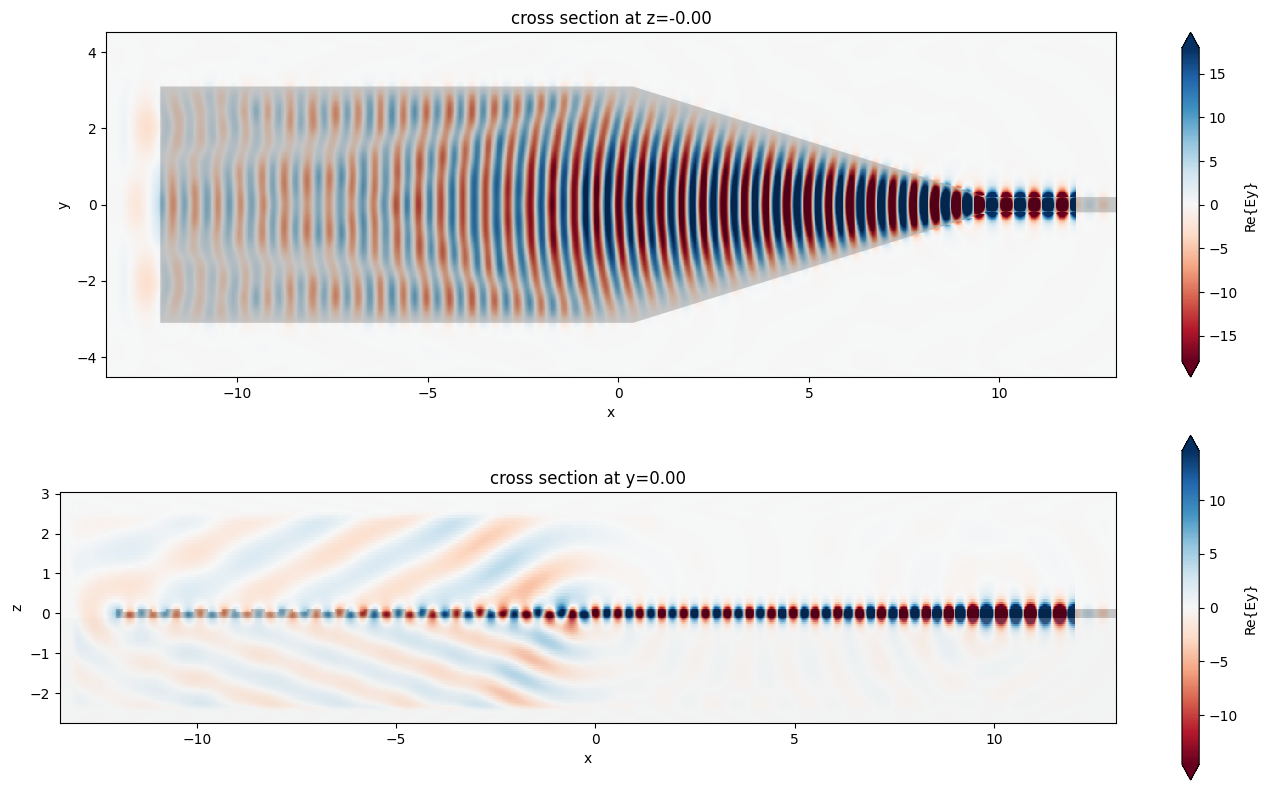

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(14, 8))
sim_data.plot_field("full_domain_fields", "Ey", f=freq0, ax=ax1)
sim_data.plot_field("radiated_fields", "Ey", f=freq0, ax=ax2)
plt.show()


## Far Field Projection
Now we use the `Tidy3D`'s [FieldProjector](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldProjector.html) to compute the anglular dependence of the far field scattering based on the near field monitor.

In [17]:
# create range of angles to probe (note: polar coordinates, theta = 0 corresponds to vertical (z axis))
num_angles = 1101
thetas = np.linspace(-np.pi / 2, np.pi / 2, num_angles)

# make a near-to-far monitor specifying the observation angles and frequencies of interest
monitor_n2f = td.FieldProjectionAngleMonitor(
    center=near_field_monitor.center,
    size=near_field_monitor.size,
    normal_dir="+",
    freqs=[freq0],
    theta=thetas,
    phi=[0.0],
    name="n2f",
)

# make a near field to far field projector with the near field monitor data
near_field_surface = td.FieldProjectionSurface(
    monitor=near_field_monitor, normal_dir="+"
)
n2f = td.FieldProjector(sim_data=sim_data, surfaces=[near_field_surface])

# compute the far_fields
far_fields = n2f.project_fields(monitor_n2f)

# Compute the scattered cross section
Ps = np.abs(far_fields.radar_cross_section.sel(f=freq0).values[0, ...])


12:57:45 UTC WARNING: Colocating data that has already been colocated during the
             solver run. For most accurate results when colocating to custom    
             coordinates set 'Monitor.colocate' to 'False' to use the raw data  
             on the Yee grid and avoid double interpolation. Note: the default  
             value was changed to 'True' in Tidy3D version 2.4.0.               

Output()

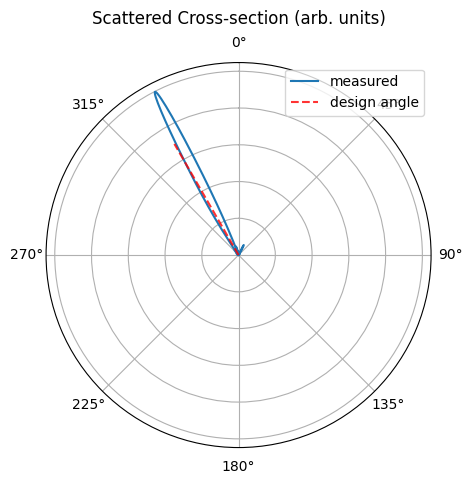

In [18]:
# plot the angle dependence
fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(5, 5))
ax.plot(thetas, Ps, label="measured")
ax.plot(
    [design_theta_rad, design_theta_rad],
    [0, np.max(Ps) * 0.7],
    "r--",
    alpha=0.8,
    label="design angle",
)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels([])
ax.set_title("Scattered Cross-section (arb. units)", va="bottom")
plt.legend()
plt.show()


In [19]:
print(f"expect angle of {(design_theta_rad * 180 / np.pi):.2f} degrees")
i_max = np.argmax(Ps)
print(f"got maximum angle of {(thetas[i_max] * 180 / np.pi):.2f} degrees")


expect angle of -30.00 degrees
got maximum angle of -27.16 degrees


The agreement between the target angle and the actual emission angle of the coupler is good. The small difference comes from the fact that the design is very sensitive to the value of the effective index that we use in the coupler region, and that value depends on which waveguide height we pick in that region: the one with the grating comb, or without. In our setup, we used a thickness that is at the mid-point, but this is a heuristic choice which results in the small final mismatch in angles observed here.

## Gaussian beam into the coupler

We can also run the coupler in the opposite way, injecting a Gaussian beam from above and monitoring the transmission into the waveguide. We will use the measured angle rather than the design angle to see the highest in-coupling efficiency that we can obtain.

In [20]:
gaussian_beam = td.GaussianBeam(
    size=(td.inf, td.inf, 0),
    center=[-8, 0, 2],
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    angle_theta=27.16 * np.pi / 180,
    angle_phi=np.pi,
    direction="-",
    waist_radius=2,
    pol_angle=np.pi / 2,
)

mode_mon = ms.to_monitor(freqs=[freq0], name="coupled")

flux_mon = td.FluxMonitor(
    size=mode_mon.size,
    center=mode_mon.center,
    freqs=[freq0],
    name="flux",
)


sim2 = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[sub, wg, cp, tp] + gratings,
    sources=[gaussian_beam],
    monitors=[plane_monitor, rad_monitor, mode_mon, flux_mon],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
)


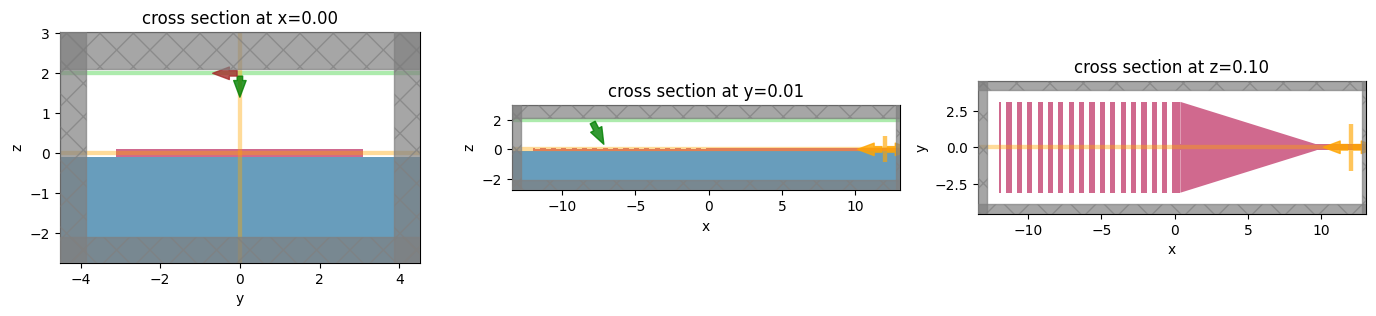

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(14, 3))
sim2.plot(x=0, ax=ax1)
sim2.plot(y=0.01, ax=ax2)
sim2.plot(z=0.1, ax=ax3)
plt.show()


In [22]:
job2 = web.Job(simulation=sim2, task_name="grating_coupler_beam", verbose=True)
sim_data2 = job2.run(path="data/grating_coupler.hdf5")
print(sim_data2.log)


12:57:46 UTC Created task 'grating_coupler_beam' with task_id                   
             'fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=498962;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=45242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\taskId]8;;\]8;id=498962;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\=]8;;\]8;id=991783;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\fdve]8;;\]8;id=498962;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\-64e0b3ae-c45]8;;\
             ]8;id=498962;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\1-4e01-bef9-80a0f67ef4f0']8;;\.

Output()

12:57:48 UTC status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

12:57:52 UTC status = preprocess

12:57:56 UTC Maximum FlexCredit cost: 1.622. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

12:58:29 UTC early shutoff detected at 16%, exiting.

             status = postprocess

Output()

12:58:31 UTC status = success

12:58:32 UTC View simulation result at                                          
             ]8;id=236238;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=116948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\taskId]8;;\]8;id=236238;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\=]8;;\]8;id=718073;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\fdve]8;;\]8;id=236238;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\-64e0b3ae-c45]8;;\
             ]8;id=236238;https://tidy3d.simulation.cloud/workbench?taskId=fdve-64e0b3ae-c451-4e01-bef9-80a0f67ef4f0\1-4e01-bef9-80a0f67ef4f0']8;;\.

Output()

12:58:40 UTC loading simulation from data/grating_coupler.hdf5

[12:57:52] USER: Simulation domain Nx, Ny, Nz: [1157, 334, 102]                 
           USER: Applied symmetries: (0, 0, 0)                                  
           USER: Number of computational grid points: 4.0500e+07.               
           USER: Subpixel averaging method: SubpixelSpec(attrs={},              
           dielectric=PolarizedAveraging(attrs={}, type='PolarizedAveraging'),  
           metal=Staircasing(attrs={}, type='Staircasing'),                     
           pec=PECConformal(attrs={}, type='PECConformal',                      
           timestep_reduction=0.3), type='SubpixelSpec')                        
           USER: Number of time steps: 1.3518e+05                               
           USER: Automatic shutoff factor: 1.00e-05                             
           USER: Time step (s): 3.8247e-17                                      
           USER:                                                                
                            

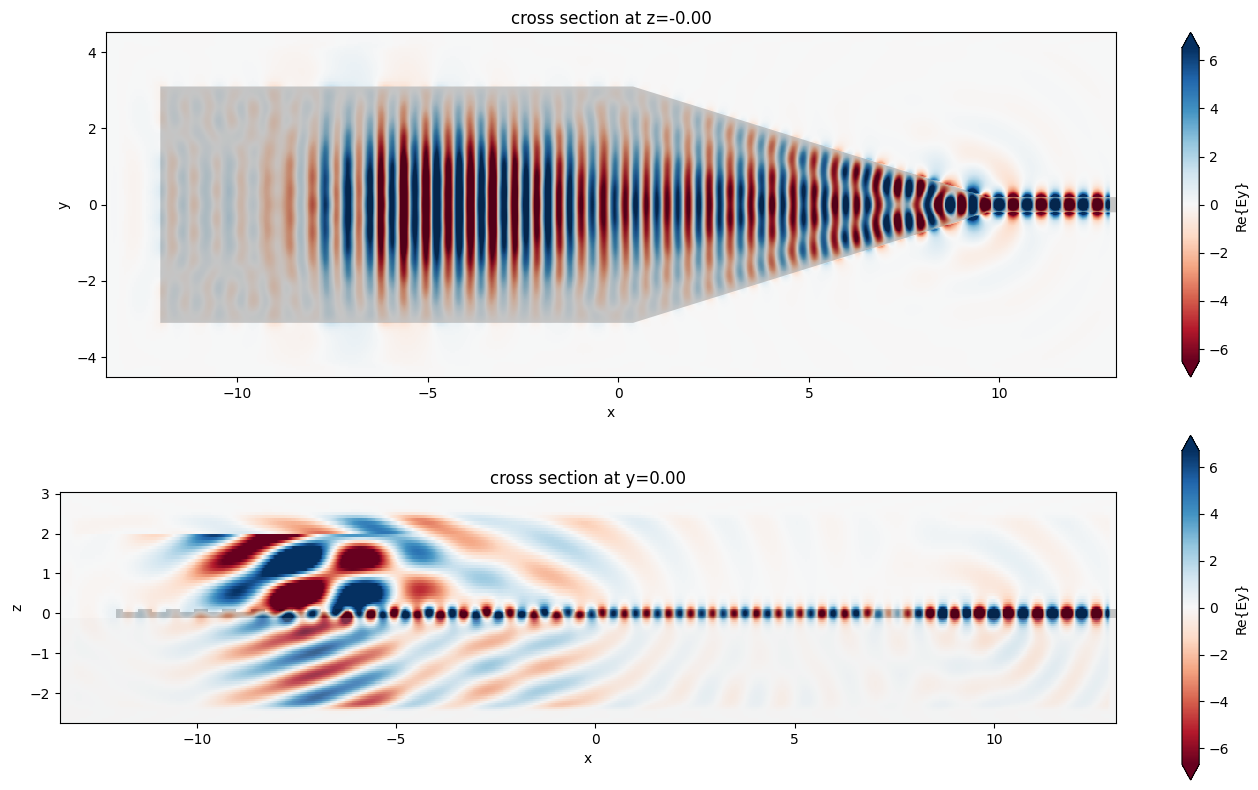

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, tight_layout=True, figsize=(14, 8))
sim_data2.plot_field("full_domain_fields", "Ey", f=freq0, ax=ax1)
sim_data2.plot_field("radiated_fields", "Ey", f=freq0, ax=ax2)
plt.show()


In [24]:
flux = sim_data2["flux"].flux
print(f"flux in waveguide / flux in = {float(flux):.4f} ")


flux in waveguide / flux in = 0.0486 


The coupler has close to 5% in-coupling efficiency, and we did not put any effort into optimizing it beyond just defining the grating pitch to target the correct angle!